In [76]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [77]:
def setupPlots(numberPlots=1):
    r"""Setups a figure and returns the figure and axis. 
    Receives the number of plots"""
    x = min(2, numberPlots)
    y = int((numberPlots+1)/2) 
    #_ = figure(figsize=(10*x, y*6), dpi=80)
    fig, ax = plt.subplots(y,x, squeeze=False, figsize=(10*x, y*6), dpi=80)
    ax2 = []
    it = 0
    for yy in ax:
        for xx in yy:
            if(it == numberPlots):
                break
            ax2.append(xx)
            it += 1
            

    return fig, ax2

In [78]:
def thresholdImage(img, range :tuple, value, remain = True):
    r"""Receives a single channel Image, a range, and the substitute value. Elements inside (inclusive)
    that range, gets their values replaced by the value specified.
    If remain==True, the remaining pixels conserve its value, otherwise the remaining pixels are reset 2 zero"""

    mask = np.bitwise_and(img<=range[1], img>=range[0])
    mask2 = np.bitwise_not(mask)
    if(remain == False):
        return mask*value
    else:
        return mask*value + img*mask2

In [79]:
def negateImage(img, K=255):
    r"""Returns negated version of image in uint8!!!"""
    img2 = np.int16(img)
    img2 = img2*-1+K
    return np.uint8(img2)

In [80]:
def checkBinaryImage(img, colorRange = 255):
    r""" Receives an img and returns true if it is a binary image """
    size = img.shape
    if(len(size) != 2):
        return False;
    for row in img:
        for col in row:
            if(col != 0 and col != colorRange):
                return False
    return True

Is binary image?  True
Is binary image?  True


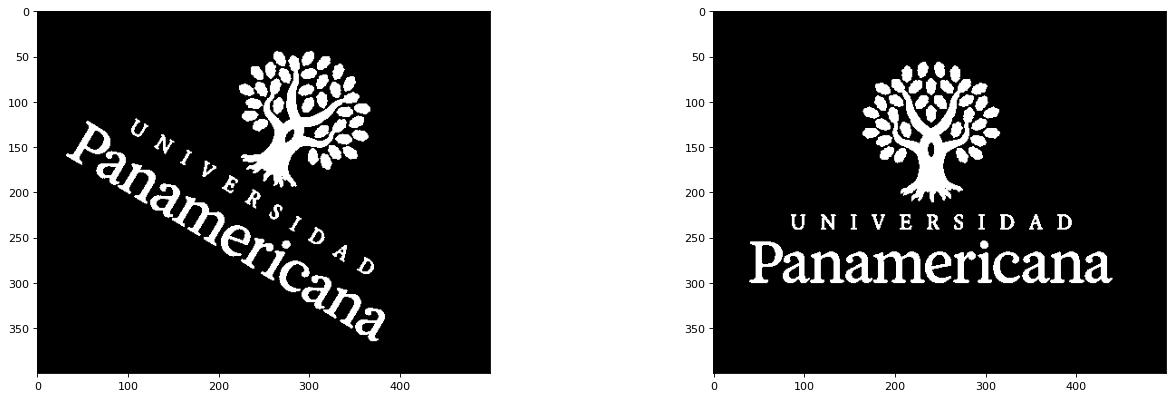

In [81]:
path = '../dataset/'
names = ['up1.PNG', 'up2.PNG']
imgs = []
for name in names:
    img = cv2.imread(path+name)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = thresholdImage(img, (240, 255), 255, False)
    #print(img)
    imgs.append(np.uint8(negateImage(img)))


fig, ax = setupPlots(len(imgs))
for a, img in  zip(ax, imgs):
    a.imshow(img, cmap = 'gray')

for img in imgs:
    print("Is binary image? ", checkBinaryImage(img))


In [82]:
def DifferenceImage(Y, Y_Pred, Positive = 255):
    r"""Calculates the F1. Positive Values are values in which the image is white (aka 255)"""
    #return np.count_nonzero(Y-Y_Pred)
    
    sum = np.uint16(Y)+ np.uint16(Y_Pred)
    tp = np.count_nonzero( sum == Positive*2)
    fpn = np.count_nonzero(sum == Positive)
    #$print("Tp and fpn", tp , fpn)
    if(tp == 0):
        return 1
    return 1 - (2*tp)/(2*tp + fpn)


    # si sumo, entonces los tp son los que me dan 255*2
    # los false positives son 255
    # los false negatives son 255

    tp = 0
    fp = 0
    fn = 0
    for r1, r2 in zip(Y, Y_Pred):
        for c1, c2 in zip(r1, r2):
            if(c2 == Positive and c1 == Positive):
                tp += 1
            if(c2 == Positive and c1 != c2):
                fp += 1
            if(c2 != Positive and c1 == Positive):
                fn += 1
    if(tp == 0):
         return 1
    return 1 - (2*tp)/(2*tp + fp + fn)

    
    

In [83]:
def getTransformationMatrix(alpha, theta, deltaX, deltaY):
    r""" Recives angle in radiants, and returns rotation matrix. Alpha is the scale value, theta the rotation, deltaX and deltaY the translation"""
    return np.float32([[alpha*math.cos(theta), 1*alpha*math.sin(theta), deltaX], [-1*alpha*math.sin(theta), alpha*math.cos(theta),deltaY], [0,0,1]])

[[   1.    0. -250.]
 [  -0.    1. -200.]
 [   0.    0.    1.]] [[ 6.123234e-17  1.000000e+00  2.500000e+02]
 [-1.000000e+00  6.123234e-17  2.000000e+02]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]] [[ 6.123234e-17  1.000000e+00  5.000000e+01]
 [-1.000000e+00  6.123234e-17  4.500000e+02]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]
0.8700714550061206


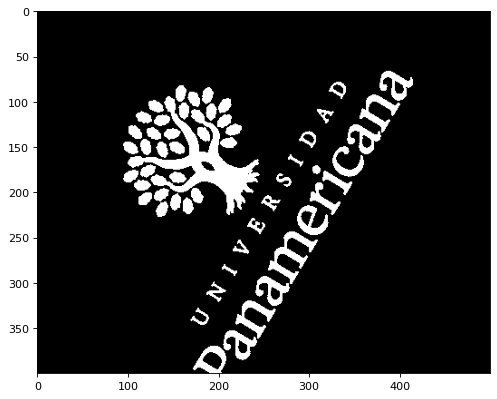

In [84]:
(rows, cols) = imgs[0].shape
#affineTransformMatrix =  getTransformationMatrix(1, 0,  -1*cols/2, -1*rows/2)
#affineTransformMatrix2 =  getTransformationMatrix(1, 0*math.pi,  -1*cols/2, -1*rows/2)
affineTransformMatrix =  getTransformationMatrix(1, 0,  -1*cols/2, -1*rows/2)
affineTransformMatrix2 =  getTransformationMatrix(1, .5*math.pi,  1*cols/2, 1*rows/2)
affineTransformMatrix3 = np.matmul(affineTransformMatrix2, affineTransformMatrix)


print(affineTransformMatrix, affineTransformMatrix2, affineTransformMatrix3)
affineTransformMatrix3 = affineTransformMatrix3[:2]
#print(np.matmul(affineTransformMatrix,np.array([[1,0], [0, 1], [1,1]])))

for i, img in enumerate(imgs):
    imgs[i] = np.uint8(img)



imgsS = cv2.warpAffine(imgs[0], affineTransformMatrix3, (cols, rows))
#imgsS = cv2.warpAffine(imgsS, affineTransformMatrix2, (cols*2, rows*2))
fig, ax = setupPlots(1)
ax[0].imshow(imgsS, cmap = 'gray')
print(DifferenceImage(imgsS, imgs[0]))

In [141]:
def createRandomSolution(rng, rows, cols):
    alpha = rng.random()+1
    theta = rng.random()*1
    deltaX = rng.random()*cols
    deltaY = rng.random()*rows
    sigmaAlpha = rng.normal(0,.1)
    sigmaTheta = rng.normal(0, 1/10)
    sigmaDeltaX = rng.normal(0, cols/10)
    sigmaDeltaY = rng.normal(0 , rows/10)
    return (alpha, theta, deltaX, deltaY, sigmaAlpha, sigmaTheta, sigmaDeltaX, sigmaDeltaY)


1


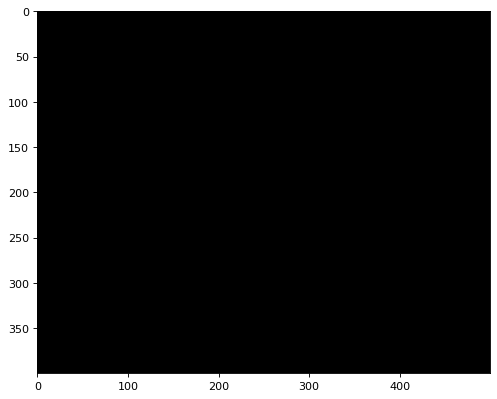

In [142]:
#rng = np.random.default_rng(16072001)
rng = np.random.default_rng()
(rows, cols) = imgs[0].shape
sol = createRandomSolution(rng, rows, cols)
affineTransformMatrix =  getTransformationMatrix(sol[0], sol[1], sol[2], sol[3])
affineTransformMatrix = affineTransformMatrix[:2]

#print(np.matmul(affineTransformMatrix,np.array([[1,0], [0, 1], [1,1]])))

for i, img in enumerate(imgs):
    imgs[i] = np.uint8(img)



imgsS = cv2.warpAffine(imgs[0], affineTransformMatrix, (cols, rows))
fig, ax = setupPlots(1)
ax[0].imshow(imgsS, cmap = 'gray')
print(DifferenceImage(imgsS, imgs[0]))

In [143]:
def createPopulation(N, rng, rows, cols):
    r""" Returns a population of size N"""
    population = []
    for i in range(N):
        population.append(createRandomSolution(rng, rows, cols))
    return population

In [144]:
def getPredFromSol(X, sol):
    r""" Gets prediction from a solution"""
    alpha = sol[0]
    theta = sol[1]
    deltaX = sol[2]
    deltaY = sol[3]
    rows, cols = X.shape
    #transformM1 = getTransformationMatrix(1,0,-1*cols/2, -1*rows/2)
    transformMatrix = getTransformationMatrix(1, theta,deltaX, deltaY)
    #affineTransformMatrix =  getTransformationMatrix(1, 0,  -1*cols/2, -1*rows/2)
    #affineTransformMatrix2 =  getTransformationMatrix(1, theta*math.pi,  1*cols/2 , 1*rows/2)
    #transformMatrix = np.matmul(affineTransformMatrix2, affineTransformMatrix)
    transformMatrix = transformMatrix[:2]
    Y_Pred = cv2.warpAffine(X, transformMatrix, (cols, rows))
    return Y_Pred


In [145]:
def getFittest(X, Y, Population):
    r""" Returns fittest individual and fit score"""
    assert len(Population) > 0, f"Can't calulate the fittest member of a population of size 0"
    score = math.inf
    bestResult = Population[0]
    for sol in Population:
        Y_Pred = getPredFromSol(X, sol)
        fitness = DifferenceImage(Y, Y_Pred)
        #print(fitness)
        if(fitness < score):
            score = fitness
            bestResult = sol
    #print('Before Leaving:', s)
    return bestResult, score

In [146]:
def IntermediateRecombination(p1, p2):
    r""" Generates an offspring from 2 parents"""
    p1 = np.array(p1)
    p2 = np.array(p2)
    assert p1.shape == p2.shape, f"Parents have different shapes"
    #print(p1)
    return (p1+p2)/2

In [147]:
def DiscreteRecombination(p1, p2, rng):
    p3 = np.array([p1, p2])
    indexes = rng.random(len(p1))
    indexes *= 2
    indexes = np.int16(indexes)
    #print(indexes)
    
    return [p3[index, i] for i, index in enumerate(indexes)]

In [148]:
def GetOffSprings(n, parents, rng):
    offSpring = []
    for i in range(n):
        it = int(rng.random() * len(parents))
        it2 = int(rng.random() * len(parents))
        #offSpring.append(DiscreteRecombination(myList[it], myList[it+1]))
        offSpring.append(IntermediateRecombination(parents[it], parents[it2]))
    #print(offSpring)
    return offSpring
    



In [149]:
def Mutation(solution, rng):
    #solution = list(solutions)
    #print(solution)
    solution = (list(solution))
    for i in range(4):
        if(solution[i+4] < .003):
         solution[i+4] = .003 
    
    solution[0] += rng.normal(0, solution[4])
    solution[1] += rng.normal(0, solution[5])
    solution[2] += rng.normal(0, solution[6])
    solution[3] += rng.normal(0, solution[7])
    t = 1/math.pow(4,.5)
    solution[4] = solution[4]*math.pow(math.e,rng.normal(0,t))
    solution[5] = solution[5]*math.pow(math.e,rng.normal(0,t))
    solution[6] = solution[6]*math.pow(math.e,rng.normal(0,t))
    solution[7] = solution[7]*math.pow(math.e,rng.normal(0,t))
    return solution

In [150]:
def Mutate(solutions, rng):
    sols = []
    for solution in solutions:
        sols.append(Mutation(solution, rng))
    return sols
        

In [151]:


def GetBest(n, solutions, X, Y):
    fitnessScore = np.zeros(len(solutions))
    #print(fitnessScore)
    for i, sol in enumerate(solutions):
        Y_Pred = getPredFromSol(X, sol)
        #print(sol)
        diff = float(DifferenceImage(Y,Y_Pred))
        fitnessScore[i] = float(diff)
    dodo = [(fitnessScore[i], int(i)) for i in range(len(fitnessScore))]
    dodo = sorted(dodo)
    dodo = np.array(dodo[:n])
    dodo = np.uint16(dodo[:,1])
    sols = np.array(solutions)
    return sols[dodo]
    



0.0002458814851241664

[0.8536346417608256, 0.7211070356785595, 0.6701175527651617, 0.5998359703379694, 0.5925648021828104, 0.2644715504477191, 0.45883561643835613, 0.16629007202372548, 0.35691002768918023, 0.21382517704259596, 0.23765052838535272, 0.03750969470492849, 0.01907644657187102, 0.059399661781285196, 0.10758066788783993, 0.1904442640883588, 0.16967230369798614, 0.08683729433272391, 0.04882688649334177, 0.09210295305312688, 0.02167945379038505, 0.013069139966273235, 0.0431380841615564, 0.02868014939045871, 0.005260573753244069, 0.022995780590717274, 0.021708585077982345, 0.01645685350587245, 0.0329918756623101, 0.020599316877354834, 0.008260395795985809, 0.004611214755887216, 0.012748920029501676, 0.00133370770742669, 0.0002458814851241664, 0.0017914222487618314, 0.0074453887757252035, 0.00035124692658938805, 0.000773232110220734, 0.0003512716032035845, 0.001440264165525007]


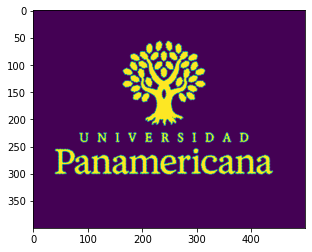

In [160]:
# Using Intermediate Recombination and Both Parents and offspiring for selection
PopSize = 200
OffSpringsSize = 400
Generations = 40
its = 0
bestIndividual = []
fitnessBest = imgs[1].size

solutions = createPopulation(PopSize, rng, rows, cols)

bestIndividual, fitnessBest = getFittest(imgs[0], imgs[1], solutions)
progress = [fitnessBest]
while(its < Generations and fitnessBest > .0001):
    
    #print(its)
    offSpring = GetOffSprings(OffSpringsSize, solutions, rng)
    solutions = list(solutions)
    solutions.extend(offSpring)
    #print(len(offSpring))
    #print(solutions)
    solutions = Mutate(solutions, rng)
    bestIndividuall, fitnessBestt = getFittest(imgs[0], imgs[1], solutions)
    if(fitnessBestt < fitnessBest):
        bestIndividual = bestIndividuall
        fitnessBest = fitnessBestt
    solutions = GetBest(PopSize, solutions, imgs[0], imgs[1])
    its += 1
    #print(fitnessBest, DifferenceImage(imgs[1], getPredFromSol(imgs[0], bestIndividual)))
    progress.append(fitnessBestt)
plt.imshow(getPredFromSol(imgs[0], bestIndividual))
print(fitnessBest)
print()
print(progress)

In [161]:
aa = getPredFromSol(imgs[0], bestIndividual)
print(DifferenceImage(imgs[1], aa))
print(500*400)
print(bestIndividual)

0.0002458814851241664
200000
[1.8710548527954192, 0.5439013877859025, -69.37107515233237, 179.48799686929382, 0.21648791818848442, 0.018915646593762075, 1.7642297378934302, 1.1559065583623385]


[0.8536346417608256, 0.7211070356785595, 0.6701175527651617, 0.5998359703379694, 0.5925648021828104, 0.2644715504477191, 0.45883561643835613, 0.16629007202372548, 0.35691002768918023, 0.21382517704259596, 0.23765052838535272, 0.03750969470492849, 0.01907644657187102, 0.059399661781285196, 0.10758066788783993, 0.1904442640883588, 0.16967230369798614, 0.08683729433272391, 0.04882688649334177, 0.09210295305312688, 0.02167945379038505, 0.013069139966273235, 0.0431380841615564, 0.02868014939045871, 0.005260573753244069, 0.022995780590717274, 0.021708585077982345, 0.01645685350587245, 0.0329918756623101, 0.020599316877354834, 0.008260395795985809, 0.004611214755887216, 0.012748920029501676, 0.00133370770742669, 0.0002458814851241664, 0.0017914222487618314, 0.0074453887757252035, 0.00035124692658938805, 0.000773232110220734, 0.0003512716032035845, 0.001440264165525007]
40


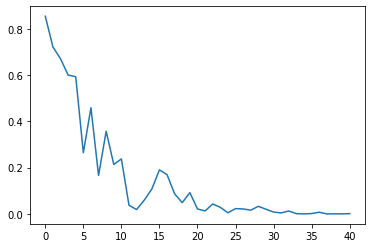

In [162]:
plt.plot(progress)
print(progress)
print(its)

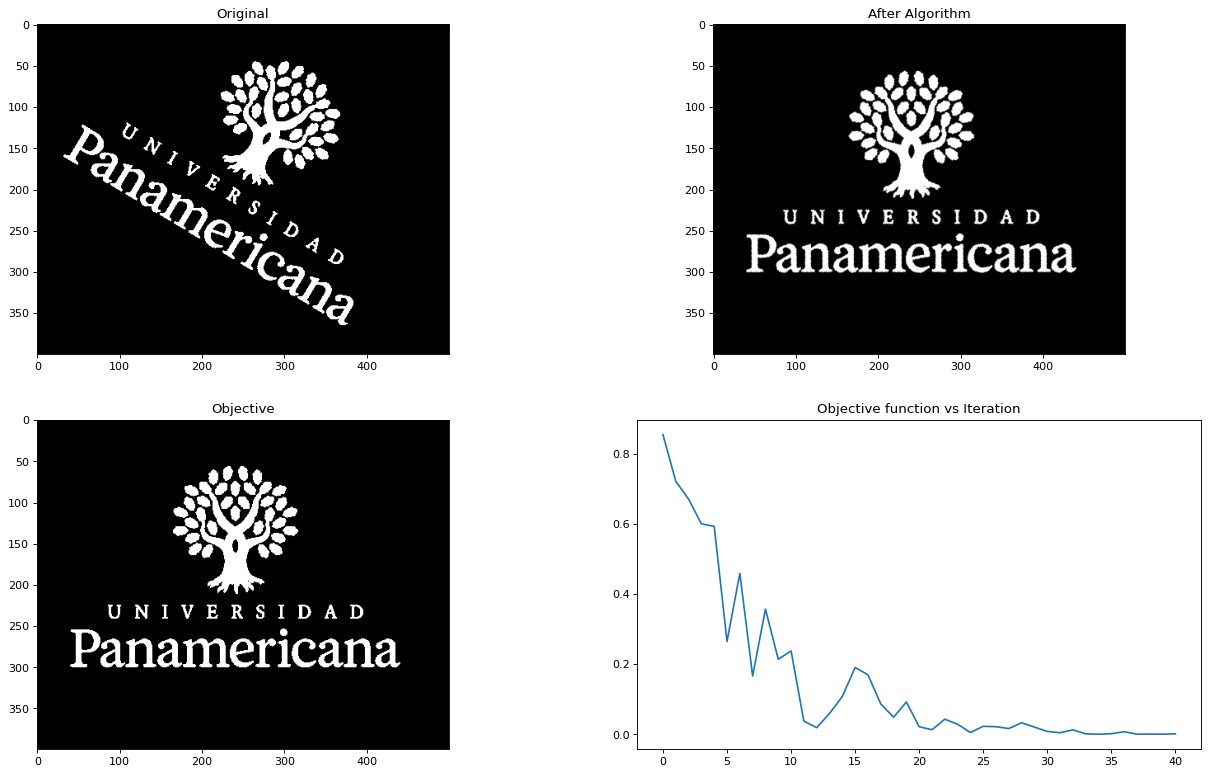

In [163]:
fig, axes =setupPlots(4)
axes[0].imshow(imgs[0], cmap = 'gray')
axes[1].imshow(aa, cmap = 'gray')
axes[2].imshow(imgs[1], cmap = 'gray')
axes[3].plot(progress)

axes[0].set_title('Original')
axes[1].set_title('After Algorithm')
axes[2].set_title('Objective')
axes[3].set_title('Objective function vs Iteration')
plt.show()